In [1]:
# add src to the sys path of this notebook
import sys
import pathlib
sys.path.append(str(pathlib.Path().absolute().parent / "src"))

from data.load_data import load_data, list_logs, load_labels
from data.preprocess_data import preprocess_logs_old, get_label_timeseries, downsample, filter
from models.helpers import create_model_params
import data.paths as config
import numpy as np
import os
from datetime import datetime
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
heads_keep = ["timestamp [s]", "Force sensor voltage [V]"]
heads_rename = ["timestamps", "force_sensor_v"]
f_s = 1000
fss = 568.5
log_names = list_logs(config.PAPER_EXPERIMENT_DATA_FOLDER)
log_names.reset_index(drop=True, inplace=True)
logs = load_data(log_names, heads_keep, heads_rename, fss)
print(f"Loaded {len(logs)} logs from paper experiments.")

Loaded 208 logs from paper experiments.


In [4]:
log_names.head()

,path,path_markers,datetime,clot_index,direction,stiffness,pressure,clot_presence
0,/home/boesch/TREX-Semester-Project/data/raw/Pa...,/home/boesch/TREX-Semester-Project/data/raw/Pa...,2022-06-30 15:38:36,1,Forward,NaN,NaN,With
1,/home/boesch/TREX-Semester-Project/data/raw/Pa...,/home/boesch/TREX-Semester-Project/data/raw/Pa...,2022-06-30 15:40:03,1,Backward,NaN,NaN,With
2,/home/boesch/TREX-Semester-Project/data/raw/Pa...,/home/boesch/TREX-Semester-Project/data/raw/Pa...,2022-06-30 15:53:54,2,Forward,NaN,NaN,With
3,/home/boesch/TREX-Semester-Project/data/raw/Pa...,/home/boesch/TREX-Semester-Project/data/raw/Pa...,2022-06-30 15:55:28,2,Backward,NaN,NaN,With
4,/home/boesch/TREX-Semester-Project/data/raw/Pa...,/home/boesch/TREX-Semester-Project/data/raw/Pa...,2022-06-30 16:04:04,3,Forward,NaN,NaN,With


In [5]:
print(f"Found {sum(log_names['direction'] == 'Backward')} logs with direction Backwards and {sum(log_names['direction'] == 'Forward')} logs with direction Forwards.")

Found 104 logs with direction Backwards and 104 logs with direction Forwards.


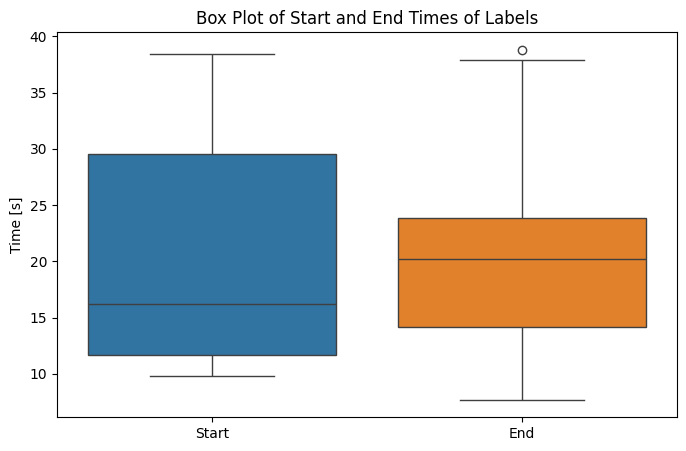

In [6]:
labels = load_labels(log_names)
labels[0].head()
# create data frame with all labels
all_labels = pd.DataFrame()
for i, label in enumerate(labels):
    label['log_index'] = i
    all_labels = pd.concat([all_labels, label], ignore_index=True)
# plot box plot of Start and End columns
plt.figure(figsize=(8, 5))
sns.boxplot(data=all_labels[['Start', 'End']])
plt.title('Box Plot of Start and End Times of Labels')
plt.ylabel('Time [s]')
plt.show()

In [7]:
# If I define accuray as being +- 1.5s from the actual start and end times, how accurate am I if I alwax predict mean start and end times?
tolerance = 1.5
for direction in ['Forward', 'Backward']:
    dir_labels = all_labels[log_names.loc[all_labels['log_index'], 'direction'] == direction]
    mean_start = dir_labels['Start'].mean()
    mean_end = dir_labels['End'].mean()
    accurate_starts = sum((dir_labels['Start'] >= mean_start - tolerance) & (dir_labels['Start'] <= mean_start + tolerance))
    accurate_ends = sum((dir_labels['End'] >= mean_end - tolerance) & (dir_labels['End'] <= mean_end + tolerance))
    total_labels = len(dir_labels)
    print(f"Direction: {direction}")
    print(f"  Accuracy for Start times: {accurate_starts}/{total_labels} ({accurate_starts/total_labels*100:.2f}%)")
    print(f"  Accuracy for End times: {accurate_ends}/{total_labels} ({accurate_ends/total_labels*100:.2f}%)")

Direction: Forward
  Accuracy for Start times: 88/104 (84.62%)
  Accuracy for End times: 16/104 (15.38%)
Direction: Backward
  Accuracy for Start times: 38/104 (36.54%)
  Accuracy for End times: 11/104 (10.58%)


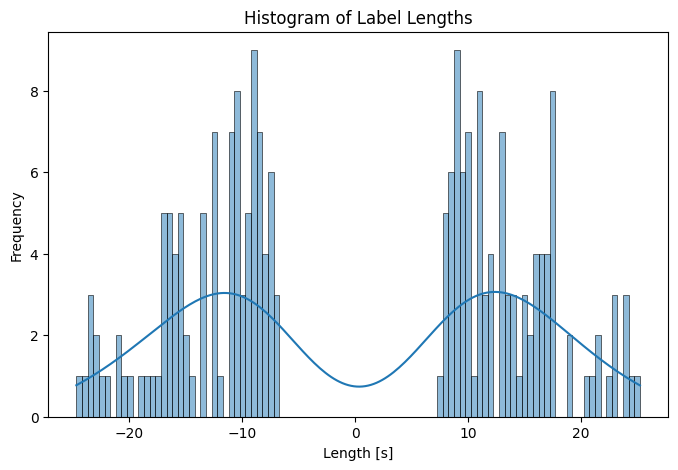

In [8]:
# histogram of length define as end - start
all_labels['Length'] = all_labels['End'] - all_labels['Start']
plt.figure(figsize=(8, 5))
sns.histplot(all_labels['Length'], bins=100, kde=True)
plt.title('Histogram of Label Lengths')
plt.xlabel('Length [s]')
plt.ylabel('Frequency')
plt.show()  

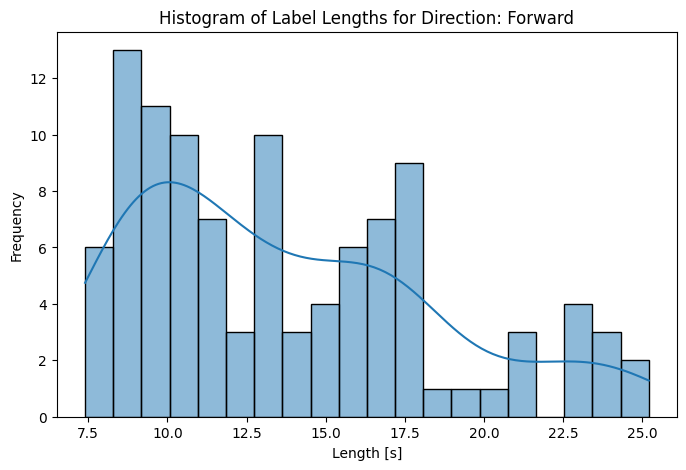

Direction: Forward, Peak Length: 10.12 s


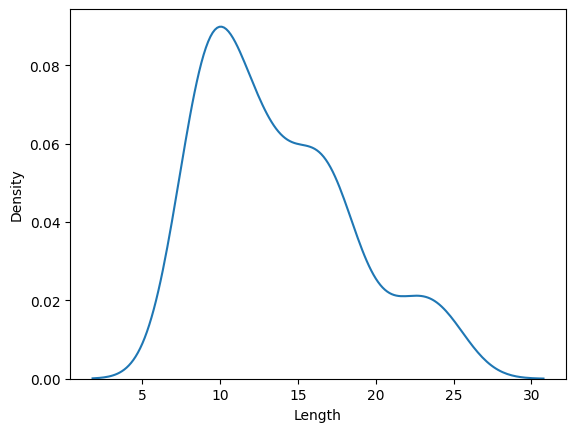

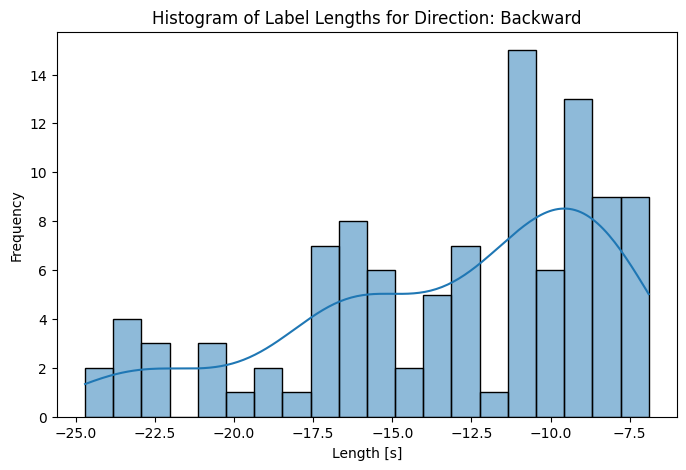

Direction: Backward, Peak Length: -9.57 s


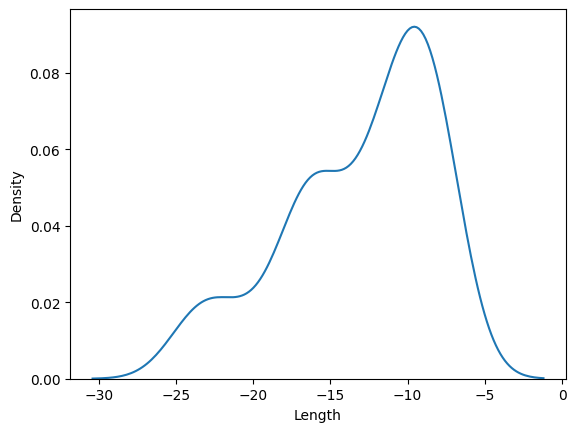

In [9]:
# histogram of length define as end - start
for direction in ['Forward', 'Backward']:
    dir_labels = all_labels[log_names.loc[all_labels['log_index'], 'direction'] == direction]
    plt.figure(figsize=(8, 5))
    sns.histplot(dir_labels['Length'], bins=20, kde=True)
    plt.title(f'Histogram of Label Lengths for Direction: {direction}')
    plt.xlabel('Length [s]')
    plt.ylabel('Frequency')
    plt.show()
    # get kde function
    kde = sns.kdeplot(dir_labels['Length'], bw_adjust=1).get_lines()[0].get_data()
    # find peak of kde
    peak_index = np.argmax(kde[1])
    peak_length = kde[0][peak_index]
    print(f"Direction: {direction}, Peak Length: {peak_length:.2f} s")

Direction: Forward, Peak Length (KDE): 10.17 s


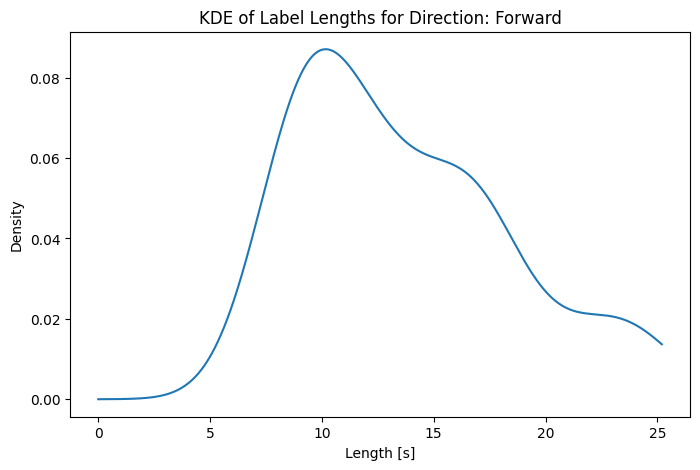

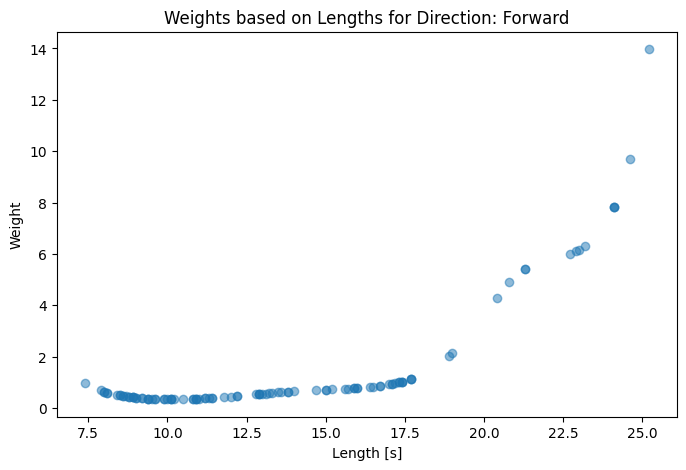

Direction: Backward, Peak Length (KDE): -6.90 s


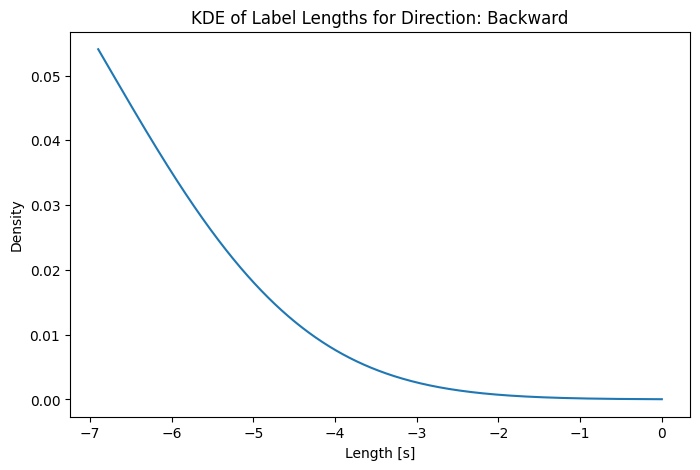

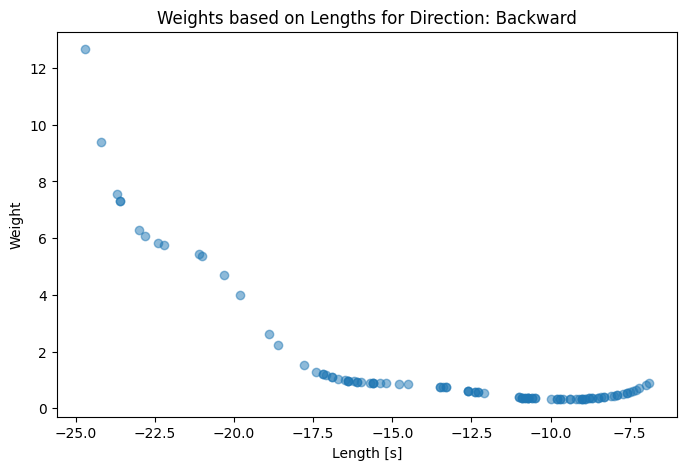

In [10]:
from sklearn.neighbors import KernelDensity
import numpy as np
alpha = 2
# lengths: numpy array of shape (N,)
for direction in ['Forward', 'Backward']:
    dir_labels = all_labels[log_names.loc[all_labels['log_index'], 'direction'] == direction]
    lengths = dir_labels['Length'].values[:, np.newaxis]
    kde = KernelDensity(kernel='gaussian', bandwidth=2).fit(lengths)
    x_d = np.linspace(0, lengths.max(), 1000)[:, np.newaxis]
    log_dens = kde.score_samples(x_d)
    peak_index = np.argmax(log_dens)
    peak_length = x_d[peak_index][0]
    print(f"Direction: {direction}, Peak Length (KDE): {peak_length:.2f} s")
    plt.figure(figsize=(8, 5))
    plt.plot(x_d[:, 0], np.exp(log_dens))
    plt.title(f'KDE of Label Lengths for Direction: {direction}')
    plt.xlabel('Length [s]')
    plt.ylabel('Density')
    plt.show()

    weights = 1 / np.exp(kde.score_samples(lengths))

    weights = weights / np.mean(weights)
    weights = weights ** 2

    plt.figure(figsize=(8, 5))
    plt.scatter(lengths, weights, alpha=0.5)
    plt.title(f'Weights based on Lengths for Direction: {direction}')
    plt.xlabel('Length [s]')
    plt.ylabel('Weight')
    plt.show()

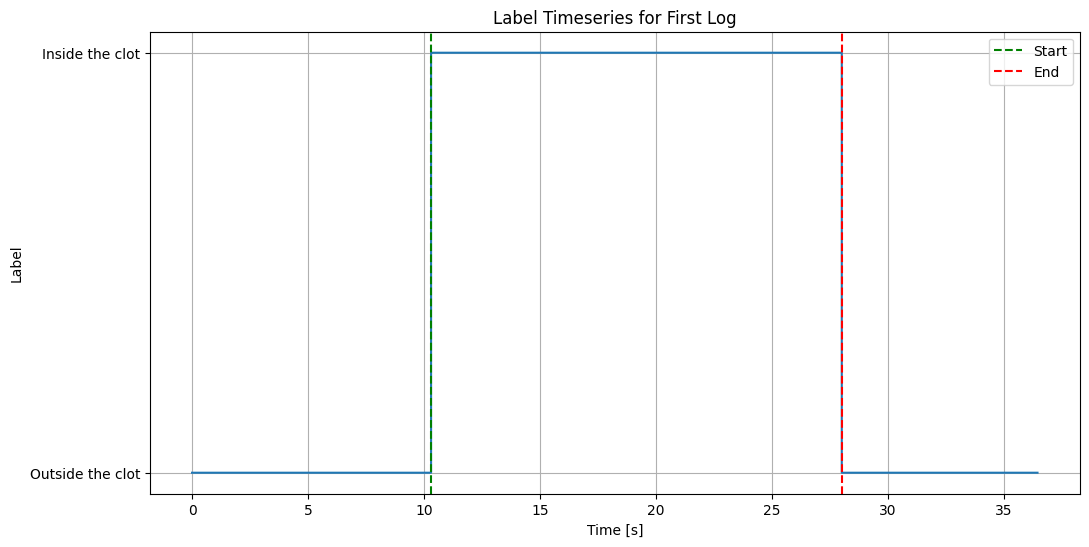

In [11]:
label_timeseries = get_label_timeseries(labels, logs)
# plot the first label timeseries
plt.figure(figsize=(12, 6))
plt.plot(label_timeseries[0]['timestamps'], label_timeseries[0]['in_clot'], drawstyle='steps-post')
# add vertical line at start and end labels 
plt.axvline(x=labels[0]['Start'].values[0], color='g', linestyle='--', label='Start')
plt.axvline(x=labels[0]['End'].values[0], color='r', linestyle='--', label='End')
plt.xlabel('Time [s]')
plt.ylabel('Label')
# make y ticks 0 and 1
plt.yticks([0, 1], ['Outside the clot', 'Inside the clot'])
plt.title('Label Timeseries for First Log')
plt.grid()
plt.legend()
plt.show()

In [12]:
logs_fit = log_names.copy()
data_fit = logs.copy()
data_fit_plot = logs.copy()

preprocess_logs_old(logs_fit, data_fit, data_fit_plot)

208it [00:03, 58.22it/s] 

Preprocessing time: 3.583 s


# Visualize the Data

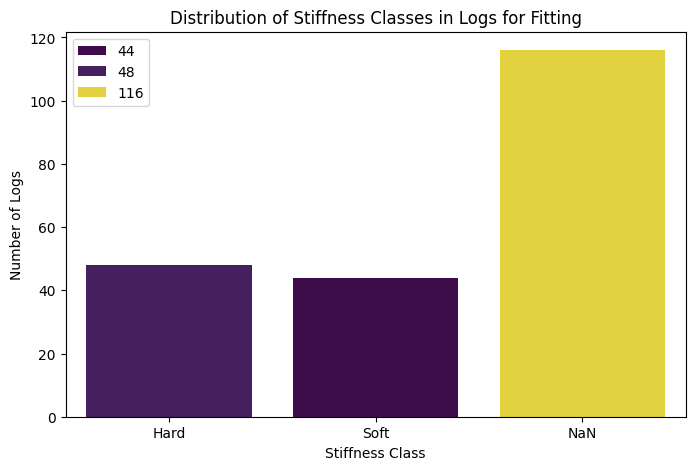

In [13]:
# visualize the distribution of stiffness classes in logs_fit
stiffness_counts = logs_fit['stiffness'].value_counts(dropna=False).sort_index()
# Replace NaN index with a readable label
labelz = ['NaN' if pd.isna(x) else x for x in stiffness_counts.index]
plt.figure(figsize=(8, 5))
sns.barplot(x=labelz, y=stiffness_counts.values, hue=stiffness_counts.values, palette="viridis", dodge=False)
plt.xlabel('Stiffness Class')
plt.ylabel('Number of Logs')
plt.title('Distribution of Stiffness Classes in Logs for Fitting')
plt.show()


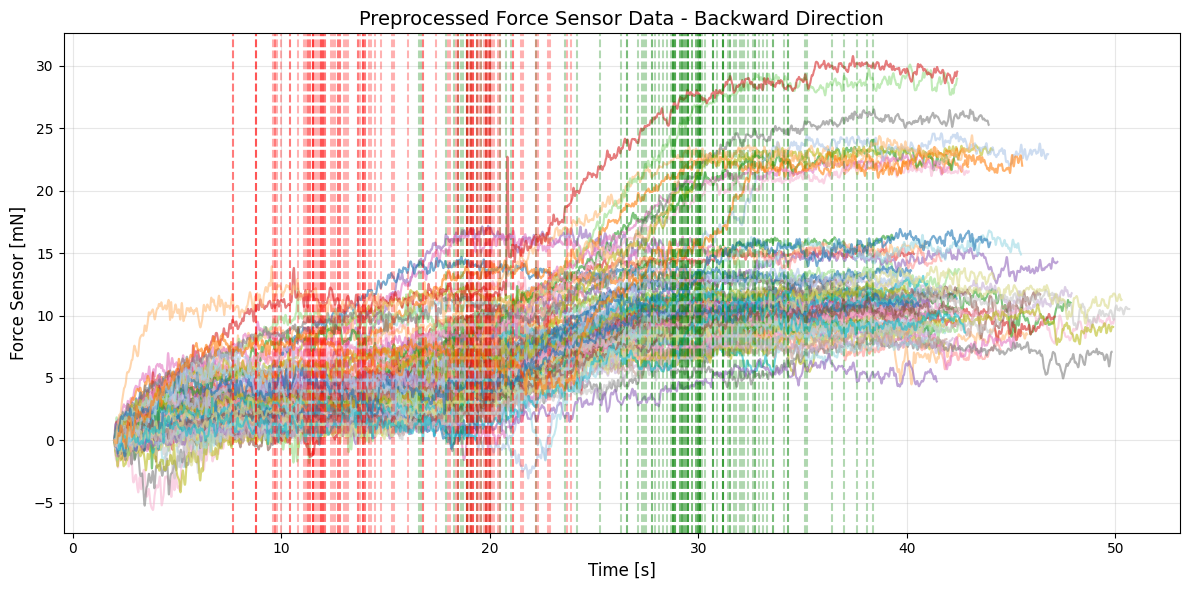

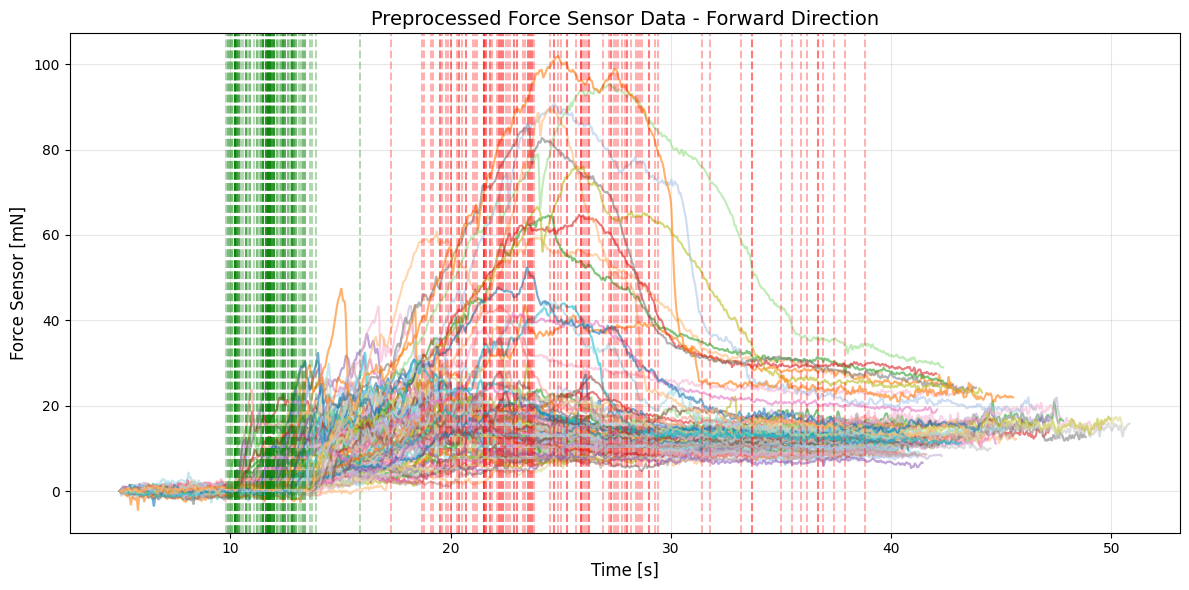

In [14]:


# Combine all curves into a single DataFrame for easier plotting
plot_data = []
for i, df in enumerate(data_fit_plot):
    df_plot = df.copy()
    df_plot['log_index'] = i
    df_plot['direction'] = logs_fit.loc[i, 'direction']
    df_plot['stiffness'] = logs_fit.loc[i, 'stiffness']
    plot_data.append(df_plot)
plot_df = pd.concat(plot_data, ignore_index=True)


for direction in ['Backward', 'Forward']:
    plt.figure(figsize=(12, 6))
    # Filter by direction
    dir_df = plot_df[plot_df['direction'] == direction]
    
    # Plot using sns.lineplot with alpha blending
    sns.lineplot(
        data=dir_df,
        x='timestamps',
        y='force_sensor_mN',
        hue='log_index',        # Different color per log
        palette='tab20',        # Color palette
        alpha=0.6,            # Transparency for overlapping curves
        legend=False            # Avoid huge legends
    )
    
    plt.title(f'Preprocessed Force Sensor Data - {direction} Direction', fontsize=14)
    plt.xlabel('Time [s]', fontsize=12)
    plt.ylabel('Force Sensor [mN]', fontsize=12)
    # plot on the x axis all the start and end times of the labels as vertical lines
    dir_labels = logs_fit[logs_fit['direction'] == direction].index
    for idx in dir_labels:
        start_time = labels[idx]['Start'].values[0]
        end_time = labels[idx]['End'].values[0]
        plt.axvline(x=start_time, color='g', linestyle='--', alpha=0.3)
        plt.axvline(x=end_time, color='r', linestyle='--', alpha=0.3)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

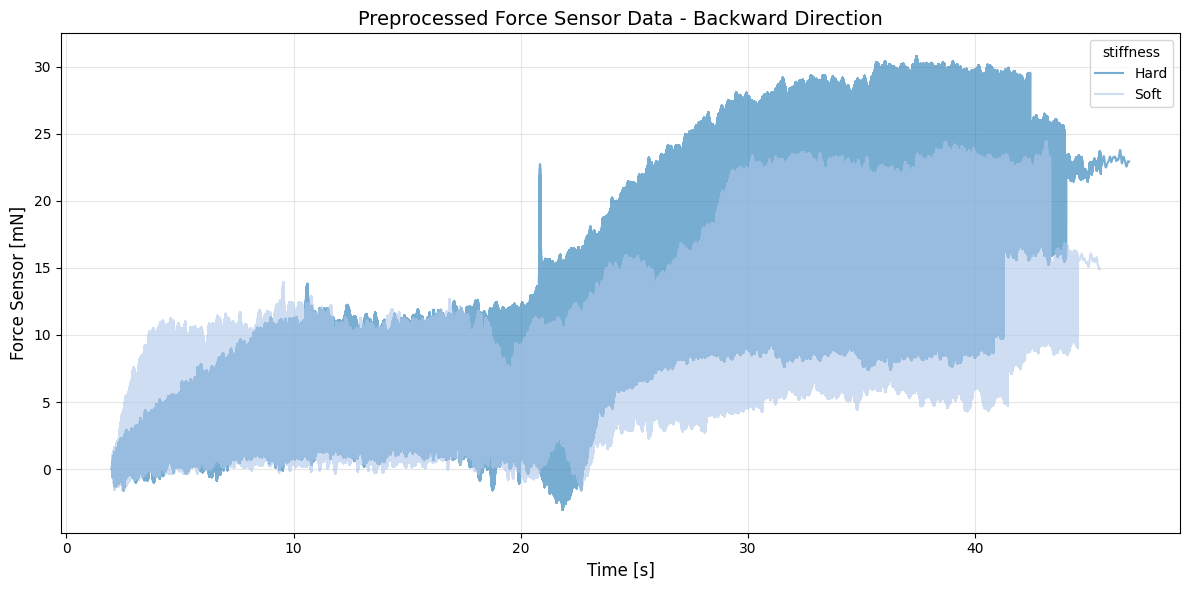

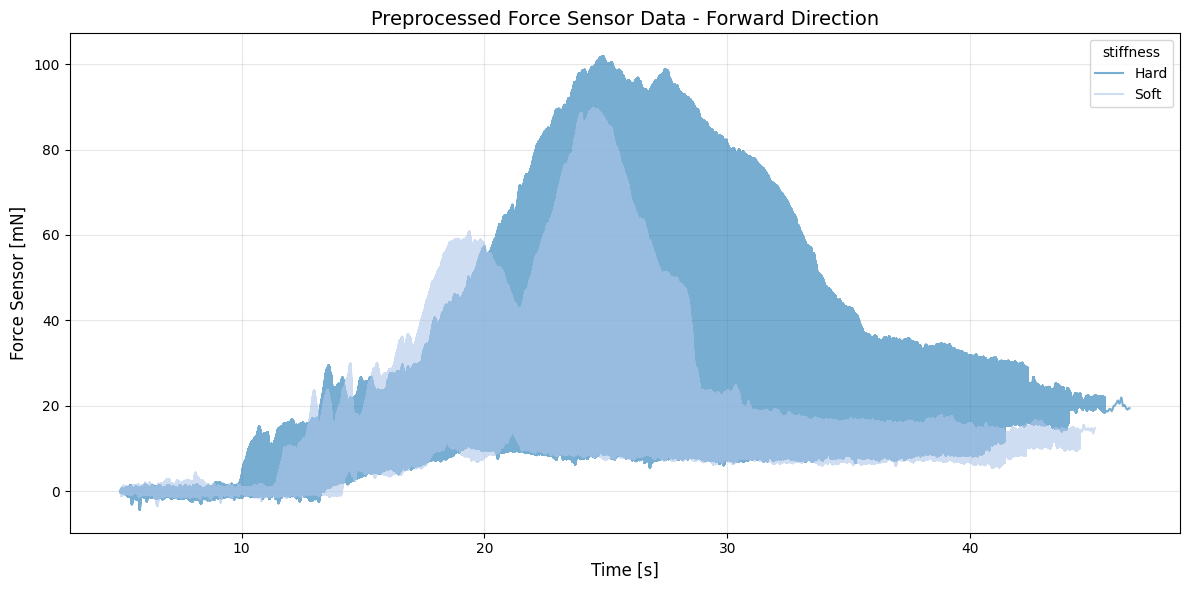

In [15]:
for direction in ['Backward', 'Forward']:
    plt.figure(figsize=(12, 6))
    # Filter by direction
    dir_df = plot_df[plot_df['direction'] == direction]
    
    # Plot using sns.lineplot with alpha blending
    sns.lineplot(
        data=dir_df,
        x='timestamps',
        y='force_sensor_mN',
        hue='stiffness',        # Different color per log
        palette='tab20',        # Color palette
        alpha=0.6,            # Transparency for overlapping curves
        estimator=None
    )
    
    plt.title(f'Preprocessed Force Sensor Data - {direction} Direction', fontsize=14)
    plt.xlabel('Time [s]', fontsize=12)
    plt.ylabel('Force Sensor [mN]', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


# Models

# Downsampling

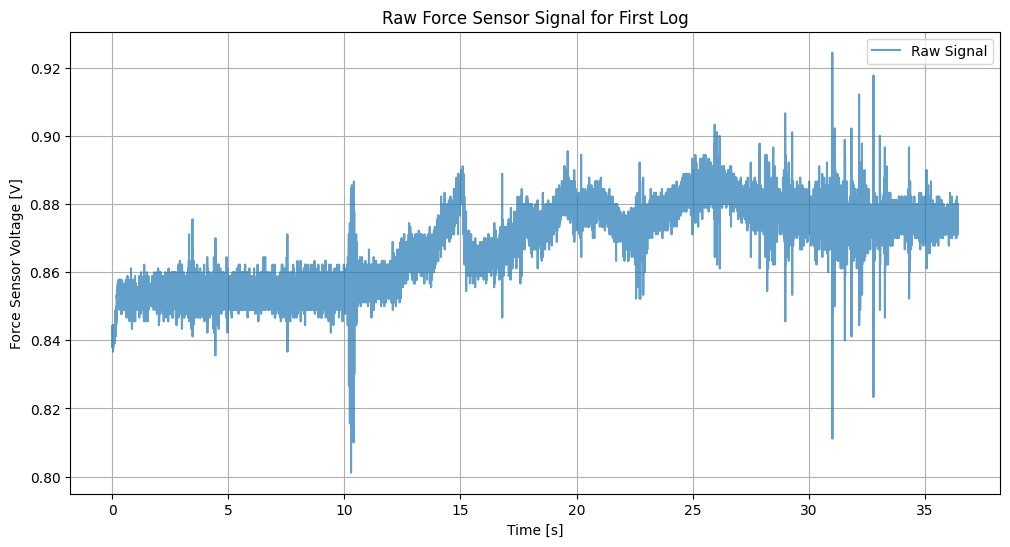

In [16]:
# plot raw signal of first log
plt.figure(figsize=(12, 6))
plt.plot(logs[0]['timestamps'], logs[0]['force_sensor_v'], label='Raw Signal', alpha=0.7)
plt.title('Raw Force Sensor Signal for First Log')
plt.xlabel('Time [s]')
plt.ylabel('Force Sensor Voltage [V]')
plt.grid()
plt.legend()
plt.show()

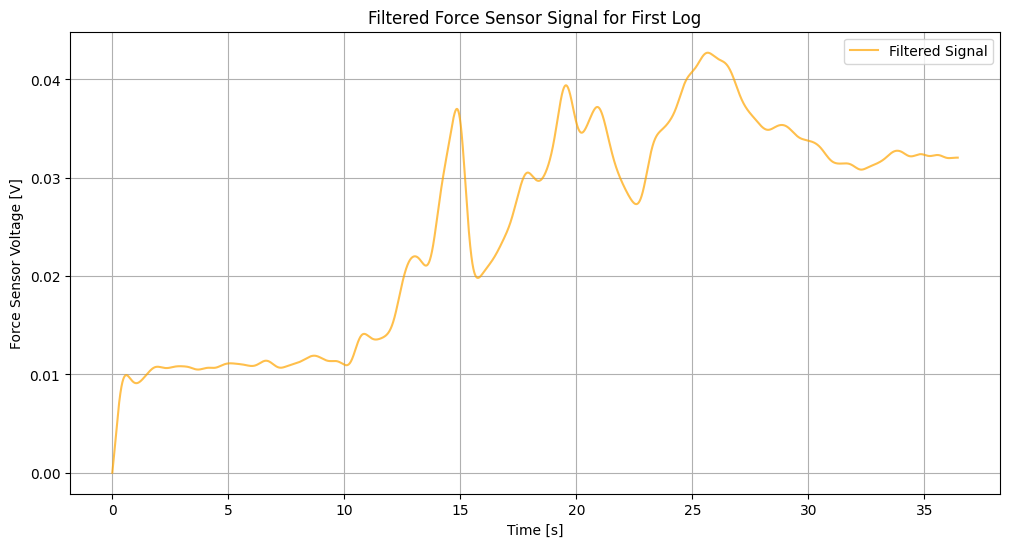

In [17]:
# plot filtered signal of first log
data = logs[0]['force_sensor_v'].values
filtered_log = filter(data, sampling_rate=1000, filter_order=3, cutoff_freq=1)
filtered_log = filtered_log - filtered_log[0]  # Adjust to start from zero
plt.figure(figsize=(12, 6))
plt.plot(logs[0]['timestamps'], filtered_log, label='Filtered Signal', color='orange', alpha=0.7)
plt.title('Filtered Force Sensor Signal for First Log')
plt.xlabel('Time [s]')
plt.ylabel('Force Sensor Voltage [V]')
plt.grid()
plt.legend()
plt.show()

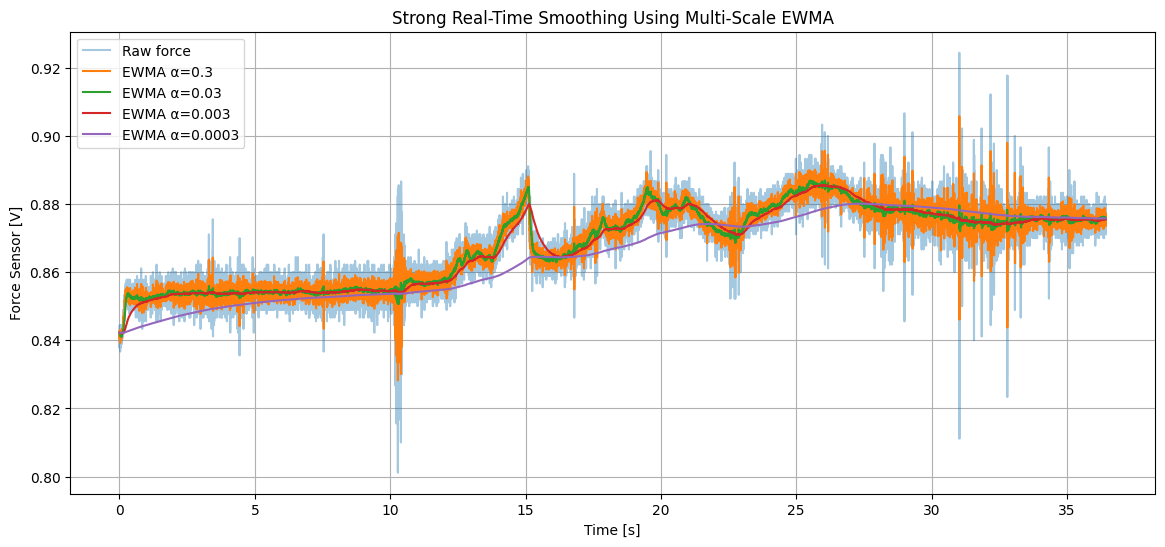

In [18]:
import numpy as np
import matplotlib.pyplot as plt

force = logs[0]["force_sensor_v"].values
time = logs[0]["timestamps"].values

# Choose strong smoothing coefficients
alphas = [0.3, 0.03, 0.003, 0.0003]   # fast → ultra-smooth

# Initialize one EWMA output per alpha
ewmas = [np.zeros_like(force) for _ in alphas]

# Initialize first values
for i in range(len(alphas)):
    ewmas[i][0] = force[0]

# Update EWMA causally
for t in range(1, len(force)):
    x = force[t]
    for i, alpha in enumerate(alphas):
        ewmas[i][t] = alpha * x + (1 - alpha) * ewmas[i][t - 1]

# Plot results
plt.figure(figsize=(14, 6))
plt.plot(time, force, alpha=0.4, label="Raw force")

for i, alpha in enumerate(alphas):
    plt.plot(time, ewmas[i], label=f"EWMA α={alpha}")

plt.title("Strong Real-Time Smoothing Using Multi-Scale EWMA")
plt.xlabel("Time [s]")
plt.ylabel("Force Sensor [V]")
plt.legend()
plt.grid()
plt.show()


# Frequency Analysis

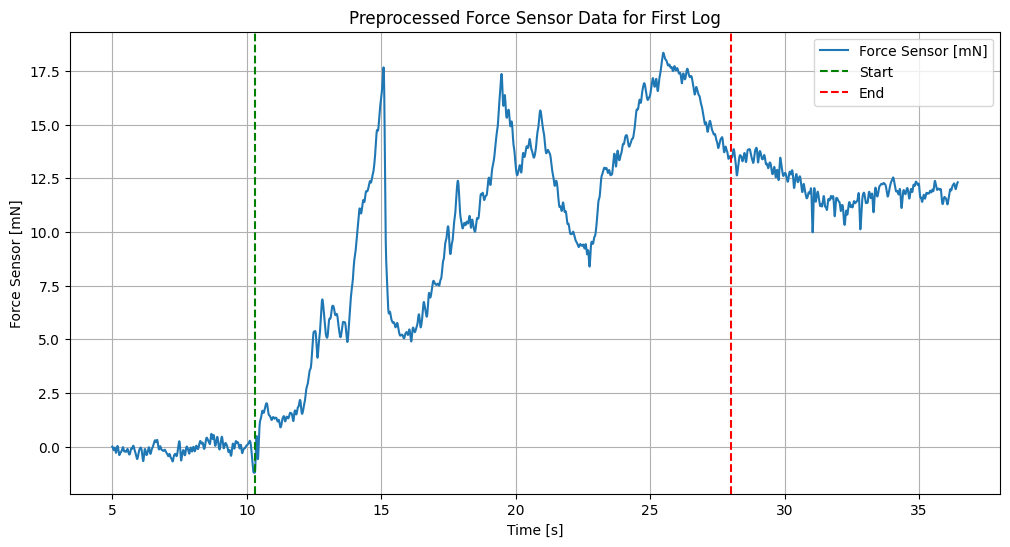

In [19]:
# plot first force curve
for i, df in enumerate(data_fit_plot[:1]):
    plt.figure(figsize=(12, 6))
    plt.plot(df['timestamps'], df['force_sensor_mN'], label='Force Sensor [mN]')
    # add vertical line at start and end labels 
    plt.axvline(x=labels[i]['Start'].values[0], color='g', linestyle='--', label='Start')
    plt.axvline(x=labels[i]['End'].values[0], color='r', linestyle='--', label='End')
    plt.xlabel('Time [s]')
    plt.ylabel('Force Sensor [mN]')
    plt.title('Preprocessed Force Sensor Data for First Log')
    plt.grid()
    plt.legend()
    plt.show()

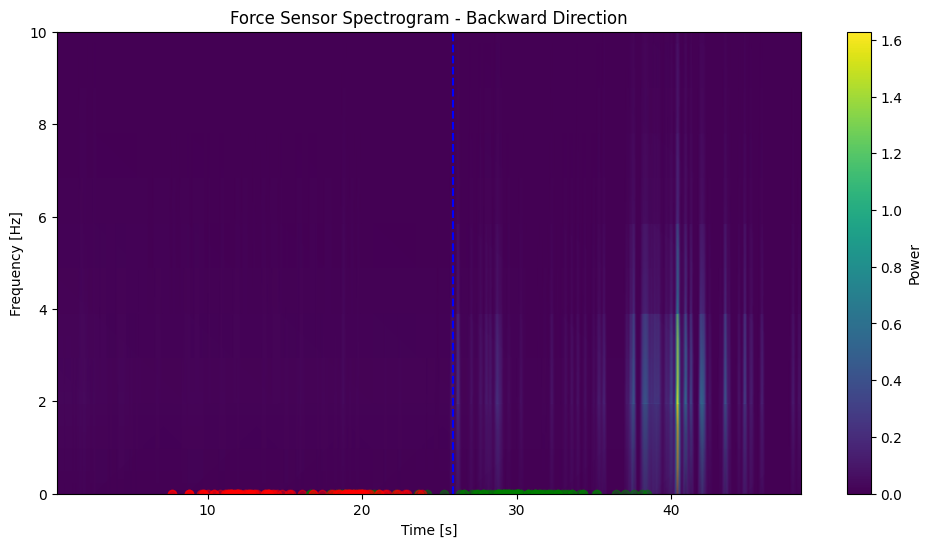

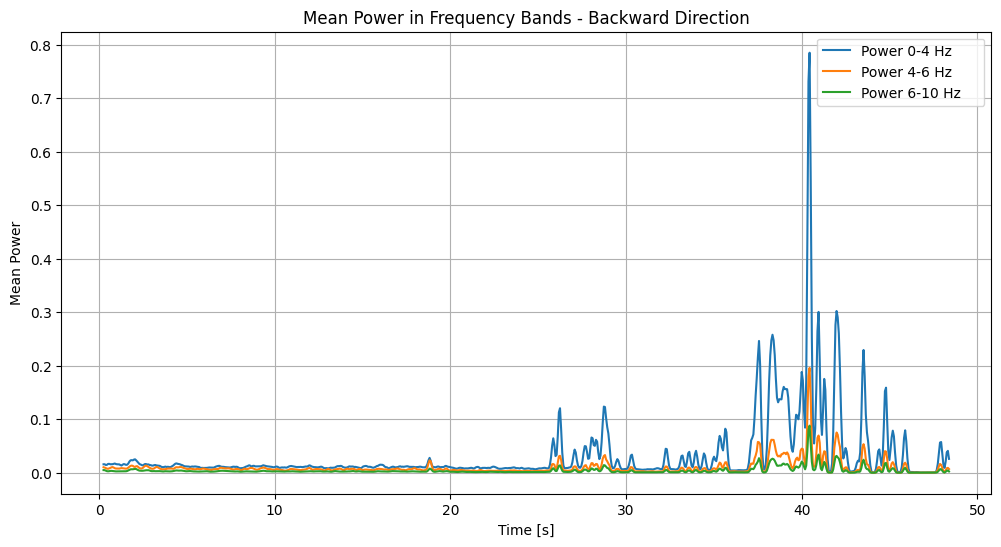

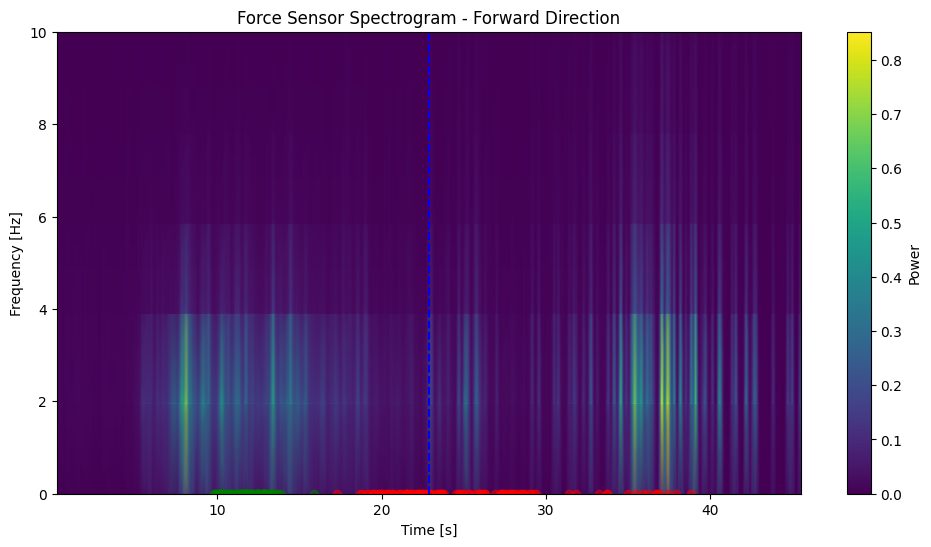

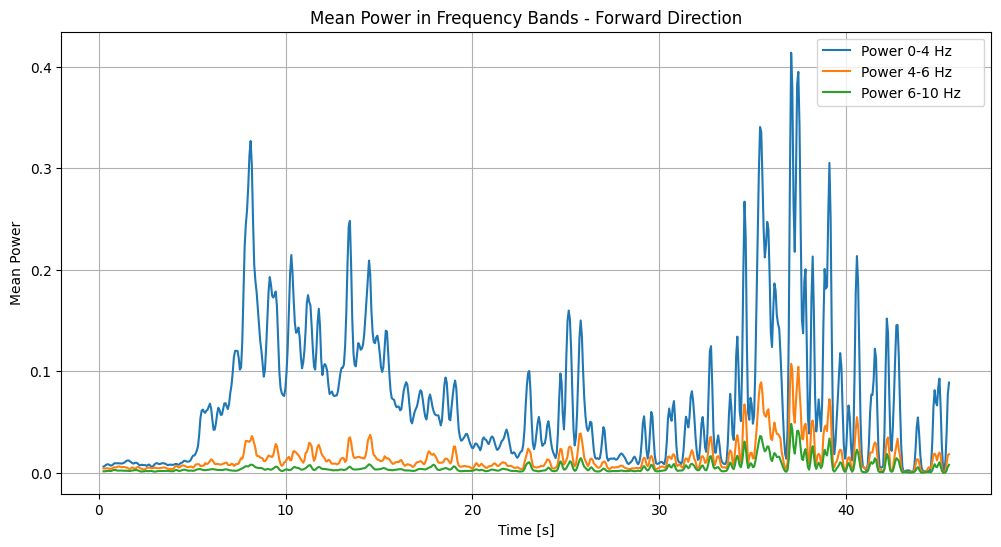

In [20]:
import matplotlib.pyplot as plt
from scipy.signal import spectrogram


for direction in ['Backward', 'Forward']:
    Sxx_tot = []
    min_length = min([len(df) for i, df in enumerate(data_fit_plot) if logs_fit.loc[i, 'direction'] == direction])
    max_length = max([len(df) for i, df in enumerate(data_fit_plot) if logs_fit.loc[i, 'direction'] == direction])
    plt.figure(figsize=(12, 6))

    for i, df in enumerate(data_fit_plot):
        if logs_fit.loc[i, 'direction'] != direction:
            continue
        force = df['force_sensor_mN'].values
        # zero pad to max_length
        if len(force) < max_length:
            force = np.pad(force, (0, max_length - len(force)), 'constant')
        fs = 1000  # sampling frequency
        f, t, Sxx = spectrogram(force, fs=fs, window='hann',
                                nperseg=512, noverlap=448,   # ≈ 90% overlap
                                scaling='density')
        Sxx_tot.append(Sxx)

    # compute mean spectrogram
    Sxx_mean = sum(Sxx_tot) / len(Sxx_tot)



    plt.pcolormesh(t, f, Sxx_mean, shading='gouraud')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [s]')
    plt.colorbar(label='Power')
    plt.title(f'Force Sensor Spectrogram - {direction} Direction')
    plt.ylim([0, 10])  # force signals often low-frequency
    # show where we start padding from 
    plt.axvline(x=min_length/1000, color='b', linestyle='--', label='Padding Start')
    for i, df in enumerate(data_fit_plot):
        if logs_fit.loc[i, 'direction'] != direction:
            continue
        plt.scatter(x=labels[i]['Start'].values[0], y=0,color='g', alpha=0.5)
        plt.scatter(x=labels[i]['End'].values[0],y=0, color='r', alpha=0.5) 
    plt.show()

    # plot mean power for band [0,4] Hz [4,6] Hz and [6,10] Hz
    power_0_4 = Sxx_mean[(f >= 0) & (f < 4), :].mean(axis=0)
    power_4_6 = Sxx_mean[(f >= 4) & (f < 6), :].mean(axis=0)
    power_6_10 = Sxx_mean[(f >= 6) & (f <= 10), :].mean(axis=0)
    plt.figure(figsize=(12, 6))
    plt.plot(t, power_0_4, label='Power 0-4 Hz')
    plt.plot(t, power_4_6, label='Power 4-6 Hz')
    plt.plot(t, power_6_10, label='Power 6-10 Hz    ')
    plt.title(f'Mean Power in Frequency Bands - {direction} Direction')
    plt.xlabel('Time [s]')
    plt.ylabel('Mean Power')
    plt.legend()
    plt.grid()
    plt.show()




In [21]:
from scipy.signal import spectrogram
import numpy as np

def compute_band_power_highres(df_original, df_down, head, bands=[(0,4),(4,6),(6,10)], fs_original=1000):
    """
    df_original: full-resolution signal
    df_down: downsampled signal (timestamps must match downsampled points)
    head: signal column
    bands: list of frequency bands
    fs_original: sampling rate of the original signal
    """
    signal = df_original[head].values
    # STFT on full-res signal
    f, t_stft, Sxx = spectrogram(signal, fs=fs_original, window='hann',
                                 nperseg=512, noverlap=448, scaling='density')
    
    # Sxx shape: (freq_bins, time_bins)
    Sxx = Sxx.T  # shape: (time_bins, freq_bins)
    
    # Interpolate to downsampled timestamps
    # Convert STFT times to indices
    stft_sample_indices = t_stft * fs_original  # in original sample indices
    down_sample_indices = np.arange(len(df_down)) * (len(df_original)/len(df_down))
    
    band_powers = np.zeros((len(df_down), len(bands)))
    for i, (f_low, f_high) in enumerate(bands):
        idx = np.where((f >= f_low) & (f < f_high))[0]
        if len(idx) == 0:
            band_power = np.zeros(len(t_stft))
        else:
            band_power = Sxx[:, idx].mean(axis=1)
        # interpolate to downsampled length
        band_powers[:, i] = np.interp(down_sample_indices, stft_sample_indices, band_power)
    
    return band_powers

Text(0.5, 1.0, 'Band Powers for First Log')

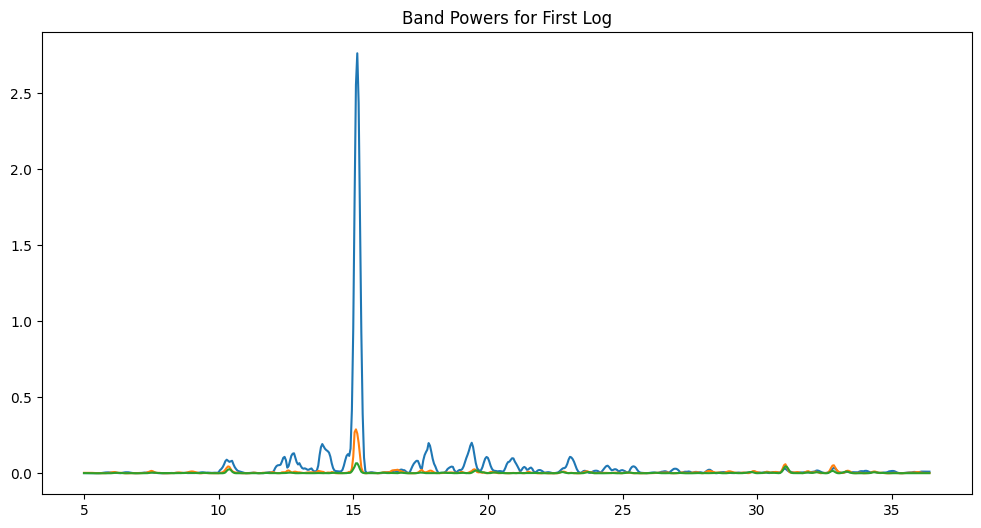

In [22]:
band_powers = compute_band_power_highres(data_fit_plot[0], data_fit[0], 'force_sensor_mN')
plt.figure(figsize=(12, 6))
plt.plot(data_fit[0]['timestamps'], band_powers[:, 0], label='Power 0-4 Hz')
plt.plot(data_fit[0]['timestamps'], band_powers[:, 1], label='Power 4-6 Hz')
plt.plot(data_fit[0]['timestamps'], band_powers[:, 2], label='Power 6-10 Hz')
plt.title('Band Powers for First Log')

# BandPowers with windows

Raw data length: 36437, High-res data length: 31437, Downsampled data length: 629


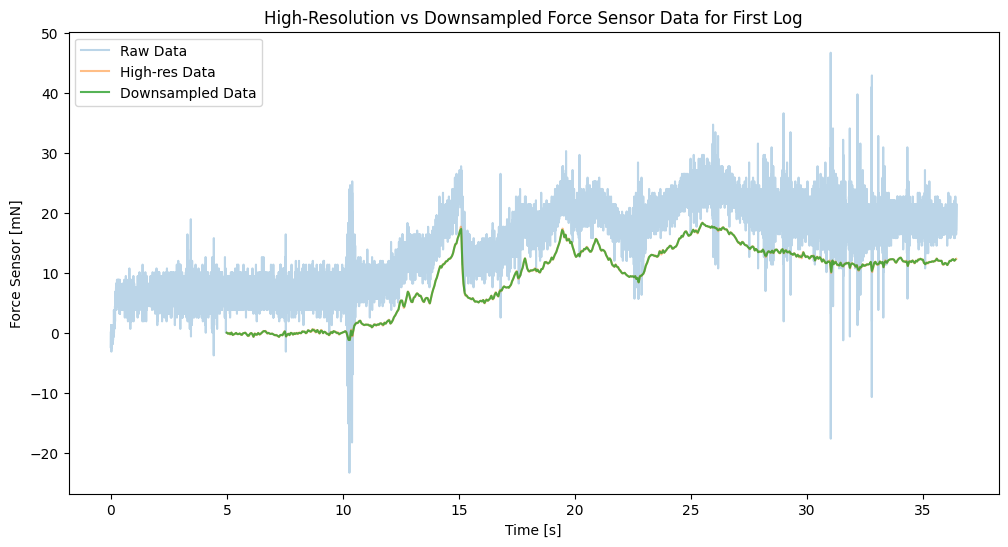

In [23]:
data_raw = logs[0]['force_sensor_mN'].values
# normalize raw data to start from zero
data_raw = data_raw - data_raw[0]
data_hres = data_fit_plot[0]['force_sensor_mN'].values
data_down = data_fit[0]['force_sensor_mN'].values
print(f"Raw data length: {len(data_raw)}, High-res data length: {len(data_hres)}, Downsampled data length: {len(data_down)}")
# plot data down
plt.figure(figsize=(12, 6))
plt.plot(logs[0]['timestamps'], data_raw, label='Raw Data', alpha=0.3)
plt.plot(data_fit_plot[0]['timestamps'], data_hres, label='High-res Data', alpha=0.5)
plt.plot(data_fit[0]['timestamps'], data_down, label='Downsampled Data', alpha=0.8)
plt.xlabel('Time [s]')
plt.ylabel('Force Sensor [mN]')     
plt.title('High-Resolution vs Downsampled Force Sensor Data for First Log')
plt.legend()

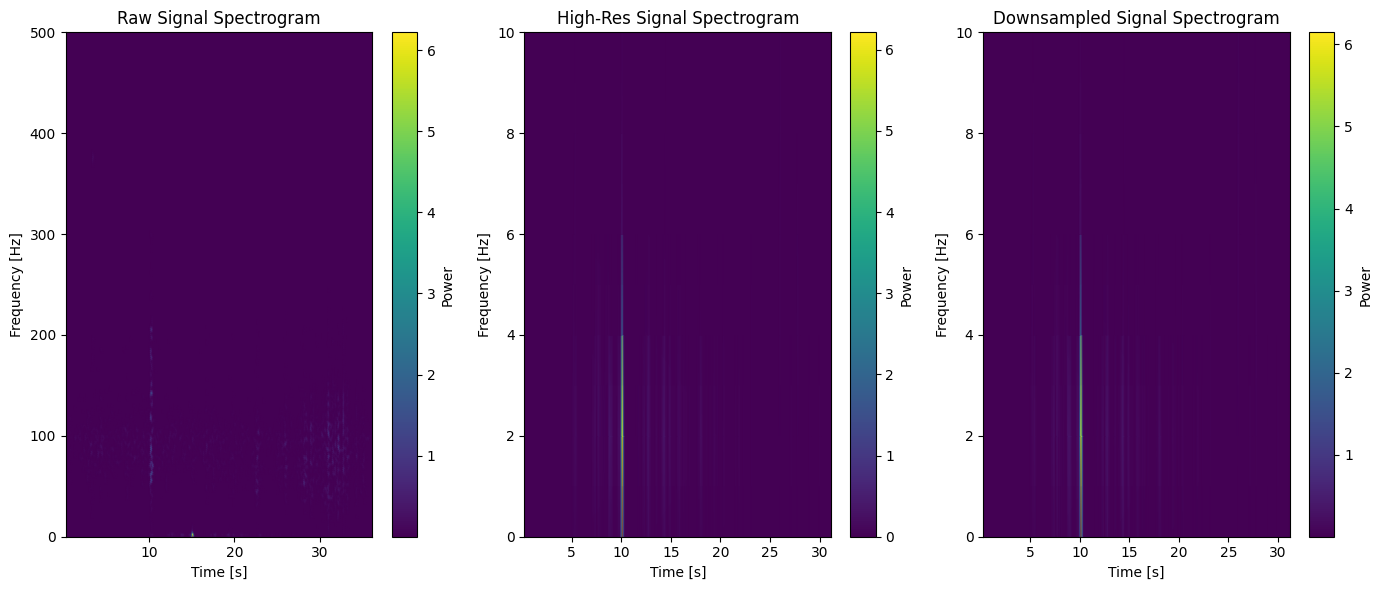

In [24]:
# compute stft for both signals and plot spectrograms side by side
f_raw, t_raw, Sxx_raw = spectrogram(data_raw, fs=1000, window='hann',
                                   nperseg=500, noverlap=450, scaling='density')
f_hres, t_hres, Sxx_hres = spectrogram(data_hres, fs=1000, window='hann',
                                       nperseg=500, noverlap=450, scaling='density')
f_down, t_down, Sxx_down = spectrogram(data_down, fs=20  , window='hann',
                                       nperseg=10, noverlap=9, scaling='density')    
plt.figure(figsize=(14, 6))
plt.subplot(1, 3, 1)
plt.pcolormesh(t_raw, f_raw, Sxx_raw, shading='gouraud')
plt.title('Raw Signal Spectrogram')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [s]')
plt.ylim([0, 500])
plt.colorbar(label='Power')
plt.subplot(1, 3, 2)
plt.pcolormesh(t_hres, f_hres, Sxx_hres, shading='gouraud')
plt.title('High-Res Signal Spectrogram')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [s]')
plt.ylim([0, 10])
plt.colorbar(label='Power')
plt.subplot(1, 3, 3)
plt.pcolormesh(t_down, f_down, Sxx_down, shading='gouraud')
plt.title('Downsampled Signal Spectrogram')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [s]')
plt.ylim([0, 10])
plt.colorbar(label='Power')
plt.tight_layout()
plt.show()

In [25]:
# compute mean fft accroos all raw signal 
for data in logs:
    signal = data['force_sensor_mN'].values 

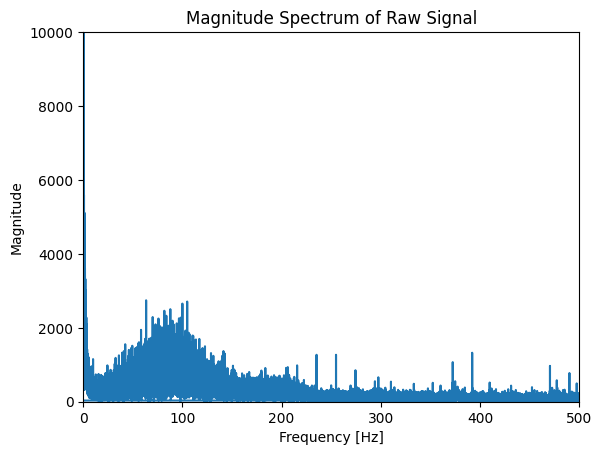

In [26]:
# compute FT of the whole raw signal using scipy.fft
import scipy.fft
fft_raw = scipy.fft.fft(data_raw)
frequencies_raw = scipy.fft.fftfreq(len(data_raw), d=1/1000)
# plot the magnitude spectrum
plt.plot(frequencies_raw, np.abs(fft_raw))
plt.title('Magnitude Spectrum of Raw Signal')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Magnitude')
plt.xlim(0, 500)
plt.ylim(0, 10000)
plt.show()

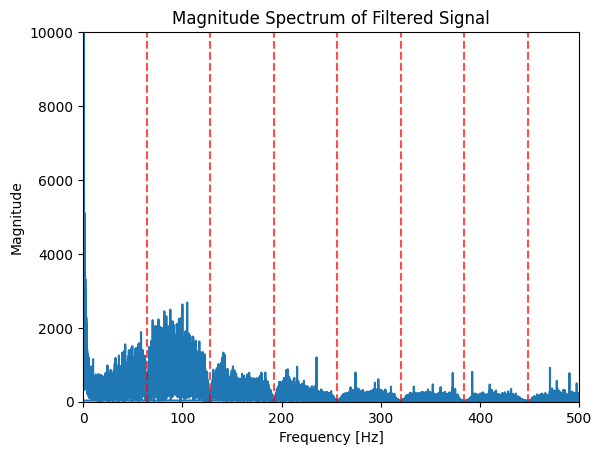

In [27]:
import numpy as np
from scipy.signal import iirnotch, filtfilt
import matplotlib.pyplot as plt
import scipy.fft

fs = 1000        # sampling rate
fundamental = 64 # change to 60 if needed
Q = 30           # quality factor

data = data_raw.copy()

# apply a notch at each harmonic up to Nyquist
for k in range(1, int((fs/2)//fundamental) + 1):
    f0 = fundamental * k
    b, a = iirnotch(f0, Q, fs)
    data = filtfilt(b, a, data)

data_filtered = data

fft_filtered = scipy.fft.fft(data_filtered)
frequencies_filtered = scipy.fft.fftfreq(len(data_filtered), d=1/1000)
# plot the magnitude spectrum
plt.plot(frequencies_filtered, np.abs(fft_filtered))
plt.title('Magnitude Spectrum of Filtered Signal')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Magnitude')
plt.xlim(0, 500)
plt.ylim(0, 10000)
# plot vline at noise frequencies
for k in range(1, int((fs/2)//fundamental) + 1):
    plt.axvline(fundamental * k, color='r', linestyle='--', alpha=0.7)
plt.show()

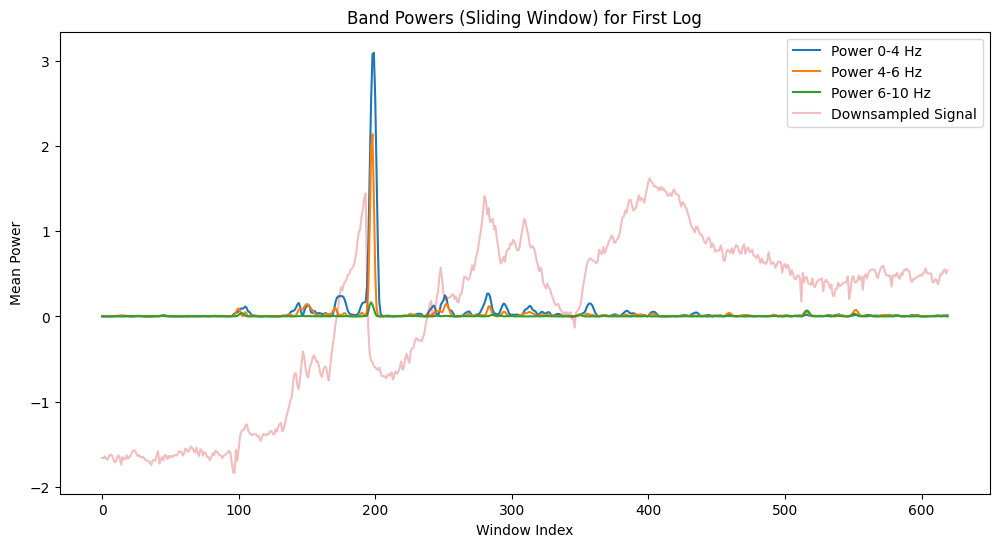

620
620


In [28]:
# compute band powers by using a sliding window on the downsampled signal for bands [0,4], [4,6], [6,10] Hz
window_size = 10 # samples
overlap = 9    # samples
step_size = window_size - overlap
num_windows = (len(data_down) - overlap) // step_size
band_powers_sliding = np.zeros((num_windows, 3))  # 3 bands
for w in range(num_windows):
    start_idx = w * step_size
    end_idx = start_idx + window_size
    segment = data_down[start_idx:end_idx]
    f_seg, t_seg, Sxx_seg = spectrogram(segment, fs=20, window='hann',
                                       nperseg=10, noverlap=9, scaling='density')
    power_0_4 = Sxx_seg[(f_seg >= 0) & (f_seg < 4), :].mean()
    power_4_6 = Sxx_seg[(f_seg >= 4) & (f_seg < 6), :].mean()
    power_6_10 = Sxx_seg[(f_seg >= 6) & (f_seg <= 10), :].mean()
    band_powers_sliding[w, 0] = power_0_4
    band_powers_sliding[w, 1] = power_4_6
    band_powers_sliding[w, 2] = power_6_10
# add zeros overlap zeros at the beginning to match length
# normalize data_down 
data_down_standardized = data_down - np.mean(data_down)
data_down_standardized = data_down_standardized / np.std(data_down_standardized)
# get rid of overlap samples at the beginning of data_down_standardized
data_down_standardized = data_down_standardized[overlap:]
plt.figure(figsize=(12, 6))
plt.plot(band_powers_sliding[:, 0], label='Power 0-4 Hz')
plt.plot(band_powers_sliding[:, 1], label='Power 4-6 Hz')
plt.plot(band_powers_sliding[:, 2], label='Power 6-10 Hz')
plt.plot(data_down_standardized, label='Downsampled Signal', alpha=0.3)
plt.title('Band Powers (Sliding Window) for First Log')
plt.xlabel('Window Index')
plt.ylabel('Mean Power')
plt.legend()
plt.show()
print(len(data_down_standardized))
print(len(band_powers_sliding[:,0]))

- use 500 Hz for bands visua insepction
- Try and use Shapely to find relevat bands
- Baesian opitmization
- Use marker from outside

# Raw signal spectrometry

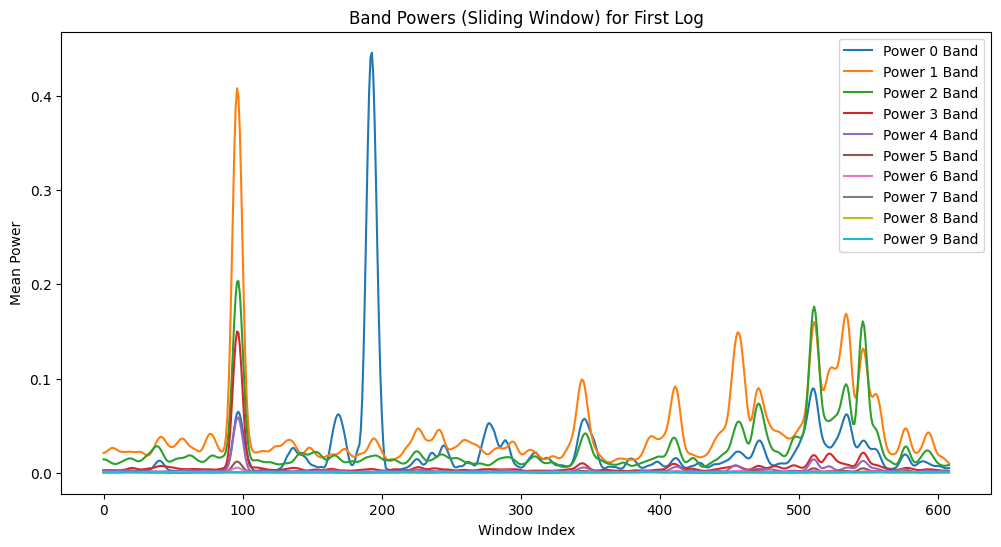

609
609


In [38]:
data_raw = logs[0].copy()
first_time = data_fit[0]["timestamps"].iloc[0]
data_raw = data_raw[(data_raw["timestamps"] >= first_time)]
data_raw = data_raw['force_sensor_mN'].values
window_size = 1000 # samples
overlap = 950    # samples
step_size = window_size - overlap
num_windows = (len(data_raw) - overlap) // step_size
n_bands = 10
band_powers_sliding = np.zeros((num_windows, n_bands))  # 10 bands
for w in range(num_windows):
    start_idx = w * step_size
    end_idx = start_idx + window_size
    segment = data_raw[start_idx:end_idx]
    f_seg, t_seg, Sxx_seg = spectrogram(segment, fs=1000, window='hann',
                                       nperseg=window_size, noverlap=overlap, scaling='density')
    power_spectrum = np.mean(Sxx_seg, axis=1)  # Average over time
    freq_bins = np.linspace(0, fs/2, n_bands + 1)
    for b in range(n_bands):
        f_low = freq_bins[b]
        f_high = freq_bins[b + 1]
        idx = np.where((f_seg >= f_low) & (f_seg < f_high))[0]
        if len(idx) == 0:
            band_power = 0
        else:
            band_power = power_spectrum[idx].mean()
        band_powers_sliding[w, b] = band_power
# normalize data_raw 
data_raw_standardized = data_raw - np.mean(data_raw)
data_raw_standardized = data_raw_standardized / np.std(data_raw_standardized)
# get rid of overlap samples at the beginning of data_raw_standardized
data_raw_standardized = data_raw_standardized[overlap:]
plt.figure(figsize=(12, 6))
for b in range(n_bands):
    plt.plot(band_powers_sliding[:, b], label=f'Power {b} Band')
plt.title('Band Powers (Sliding Window) for First Log')
plt.xlabel('Window Index')
plt.ylabel('Mean Power')
plt.legend()
plt.show()
print(len(data_raw_standardized)//50)
print(len(band_powers_sliding[:,0]))